In [1]:
"""
Created on Tuesday 9 Feb 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from scipy.optimize import curve_fit
from scipy import signal
from tsmoothie.smoother import LowessSmoother
import csv

In [93]:
# Read dataset for a , b, c value
# data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)
data = pd.read_csv(data_path)

In [94]:
path

'/Users/zaw/Desktop/eye_movements(sp)/gain'

In [95]:
# View top 10 rows in dataframe
data.head(10)

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035
5,Not_Parkinson's,PD006,10.302529,0.010450,0.049283,0.000011,0.019735,0.000580,25994.527943,0.972249,...,7175.782112,0.938474,10.356903,0.067627,0.410282,0.000584,-0.052723,0.003707,16046.923323,0.859535
6,Not_Parkinson's,PD007,9.934379,0.007838,0.049209,0.000009,0.003633,0.000449,14490.496516,0.983200,...,1465.027123,0.985896,9.801698,0.024067,0.397850,0.000217,-0.045138,0.001380,1986.965945,0.980134
7,Not_Parkinson's,PD008,9.861257,0.026999,0.049220,0.000030,0.051865,0.001576,176009.839073,0.798036,...,15508.422642,0.870504,8.591437,0.105215,0.415729,0.001098,-0.078941,0.006967,39005.324498,0.507026
8,Not_Parkinson's,PD009,10.221777,0.005149,0.049244,0.000006,0.002274,0.000287,6253.730577,0.993152,...,849.603210,0.992275,10.305625,0.022845,0.396998,0.000196,-0.056233,0.001244,1783.111545,0.983816
9,Not_Parkinson's,PD010,10.244784,0.017579,0.050004,0.000019,-0.015054,0.000981,73606.211066,0.920684,...,13818.787560,0.878166,10.997960,0.085181,0.406918,0.000690,-0.043189,0.004387,25335.919452,0.802179


In [1607]:
# read SPEM data
data_013 = 'data/Parkinson_pursuit testing_Rec 180.xlsx'
data_path = os.path.join(dirname,data_013)
data_sp = pd.read_excel(data_path)

/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


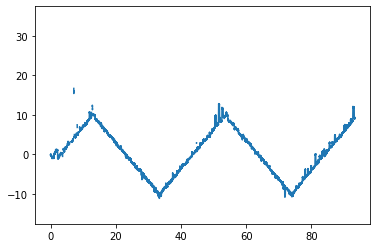

In [1696]:
plt.plot(one_deg_time_eye,one_deg_pos_eye)

In [1701]:
# Pupil size
pupil_size = np.array(data_sp['PupilRight'][0:28000])

In [1702]:
# for eye pixel calculating
def px_deg_eye(data,dominant_eye):
    time_eye = []
    pos_eye = []
    if dominant_eye == 'right':
        for y in data['GazePointRightX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    elif dominant_eye == 'left':
        for y in data['GazePointLeftX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    for x in range(1,len(pos_eye)+1):
        new_x = round((1/300)*x,4) # for tobii's eye tracker with 300 Hz sampling rate
        time_eye.append(new_x)
    return time_eye,pos_eye

In [1703]:
def filter_blinks(gaze_point_right_x, gaze_time_input, pupil_size=pupil_size, consecutive_missing_points_threshold=60):
    # Convert input list to NumPy array
    gaze_point_right_x = np.array(gaze_point_right_x)
    gaze_time = gaze_time_input

    # Create a mask for missing data (NaN) in GazePointRightX
    missing_mask = np.isnan(gaze_point_right_x) & np.isnan(pupil_size)

    # Count consecutive missing gaze points (NaNs)
    consecutive_missing_points = np.diff(np.where(np.concatenate(([missing_mask[0]], missing_mask[:-1] != missing_mask[1:], [True])))[0])[::2]

    # Count the number of blinks based on the consecutive_missing_points_threshold
    num_blinks = np.sum(consecutive_missing_points >= consecutive_missing_points_threshold)

     # Remove the missing data (NaN) using the mask
    gaze_point_right_x_no_blinks = gaze_point_right_x[~missing_mask]

    # Also remove the repective time values
    gaze_time = gaze_time[~missing_mask]

    #print(f"Number of blinks: {num_blinks}")

    return gaze_point_right_x_no_blinks, gaze_time

In [1704]:
# event starts and ends
option = ['URLStart','URLEnd'] # This is the values in the Studio event column where stimuli start and end events from dataset
sti = data_sp[data_sp['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
data_eye_hc_first = data_sp[sti[0]:sti[0]+28000] # Real recoding starting time
#data_eye_hc_first = data_sp[sti[0]+4000:sti[0]+28200] # Real recoding starting time
one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')

In [1705]:
sub_013 = {'Time':one_deg_time_eye,'POS':one_deg_pos_eye}
df_sub_013 = pd.DataFrame(data=sub_013)
#df_sub_013.to_excel('sub013.xlsx')

In [1706]:
# # filter blinks
position,time = filter_blinks(df_sub_013['POS'],df_sub_013['Time'])


data_fil= {'Time':time,'POS':position}#,#'PUP':pupil_size}
data_fil = pd.DataFrame(data_fil)
# #data_pd001['POS'] = pos_no_blinks
# Remove the spike values and interpolate
window_size = 7
data_fil['POS'] = data_fil['POS'].rolling(window=window_size, center=True).median()

# # interpolate
data_fil['POS'] = data_fil['POS'].interpolate(method='spline', order=5)

one_deg_time_eye , one_deg_pos_eye =  data_fil['Time'], data_fil['POS']

In [1707]:
# Check Nan or Inf for time
nan_mask = one_deg_time_eye.isna()
inf_mask = np.isinf(one_deg_time_eye)
non_or_inf_mask = nan_mask | inf_mask
total_nan = nan_mask.sum()
total_inf = inf_mask.sum()

nan_or_inf_mask = nan_mask | inf_mask

total_nan_or_inf = nan_or_inf_mask.sum()

# Print the results
print("Total NaN values:", total_nan)
print("Total inf values:", total_inf)
print("Total NaN and inf values:", total_nan_or_inf)

Total NaN values: 0
Total inf values: 0
Total NaN and inf values: 0


In [1708]:
# Check Nan or Inf for pos
nan_mask = one_deg_pos_eye.isna()
inf_mask = np.isinf(one_deg_pos_eye)
non_or_inf_mask = nan_mask | inf_mask
total_nan = nan_mask.sum()
total_inf = inf_mask.sum()

nan_or_inf_mask = nan_mask | inf_mask

total_nan_or_inf = nan_or_inf_mask.sum()

# Print the results
print("Total NaN values:", total_nan)
print("Total inf values:", total_inf)
print("Total NaN and inf values:", total_nan_or_inf)

Total NaN values: 4
Total inf values: 0
Total NaN and inf values: 4


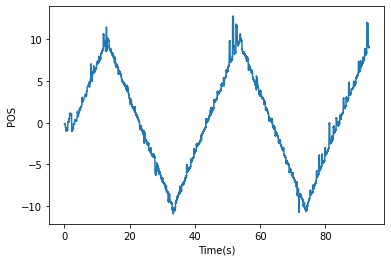

In [1709]:
# Plot the data
plt.plot(one_deg_time_eye,one_deg_pos_eye)
plt.xlabel('Time(s)')
plt.ylabel('POS')
plt.show()

In [1711]:
data['Position']


0         0.0033
1         0.0067
2         0.0100
3         0.0133
4         0.0167
          ...   
26997    89.9933
26998    89.9967
26999    90.0000
27000    90.0033
27001    90.0067
Name: Position, Length: 27002, dtype: float64

In [1712]:
y_data = one_deg_time_eye
x_data = one_deg_pos_eye

In [1714]:
y_data

0         0.0033
1         0.0067
2         0.0100
3         0.0133
4         0.0167
          ...   
27995    93.3200
27996    93.3233
27997    93.3267
27998    93.3300
27999    93.3333
Name: Time, Length: 27666, dtype: float64

### Working Algorithms

In [2450]:
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/one_deg.csv'
data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
data= pd.read_csv(data_path)

#### Test with different subjects

In [2451]:
data_hc = data[['x1_PD008','y1_PD008']]
y_data = data_hc[data_hc.columns[0]]
x_data = data_hc[data_hc.columns[1]]

In [2452]:
#plt.plot(y_data,x_data)

#### For stimulus

In [2453]:
#import CSV data
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/1_degSti.xlsx'
data_path = os.path.join(dirname,data_file)
rawdata = pd.read_excel(data_path)
data_st = np.array(rawdata[1:],dtype=np.float)
time = data_st[:,1]
position = data_st[:,0]

/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_1818/1234896519.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_st = np.array(rawdata[1:],dtype=np.float)


In [2454]:
# Trigonometric functions

# Define the function
def func(x, a, b, c):  #Position as a function of time.
    return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

#initial guesses
#for 1 degree per second: [10, 0.05, 0]
#for 2 degrees per second: [10, 0.1, 0]
#for 4 degrees per second: [10, 0.2, 0]
#for 6 degrees per second: [10, 0.3, 0]
#for 8 degrees per second: [10, 0.4, 0]
InitialGuess = [10, 0.05, 0]

# Perform curve fitting
popt, pcov = curve_fit(func,position,time, p0=InitialGuess)

# Extract the optimal values of a, b, and c
a, b, c = popt
print("a =", a)
print("b =", b)
print("c =", c)

a = 9.989903127015685
b = 0.05000044571043853
c = -2.7511974340545354e-05


In [2455]:
# # # # Trigonometric functions

# # # # Define the function
# # # def func(x, a, b, c):  #Position as a function of time.
# # #     return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

# # # # drop NaN
# # # y_data = one_deg_time_eye.ffill()
# # # x_data = one_deg_pos_eye.ffill()

# # # y_data = one_deg_time_eye.bfill()
# # # x_data = one_deg_pos_eye.bfill()

# # # # # Example data points (x, y) - replace these with your actual data
# # # # x_data = np.array(one_deg_time_eye)
# # # # y_data = np.array(one_deg_pos_eye)


# # # #initial guesses
# # InitialGuess = [10, 0.05, 0]

# # # Perform curve fitting
# # popt, pcov = curve_fit(func, x_data, y_data, p0=InitialGuess)

# # # Extract the optimal values of a, b, and c
# # a, b, c = popt

# # print("Optimal values of a, b, and c:")
# print("a =", a)
# print("b =", b)
# print("c =", c)

In [2456]:
# a = 10.19274
# b = 0.04942
# c = 0.00533

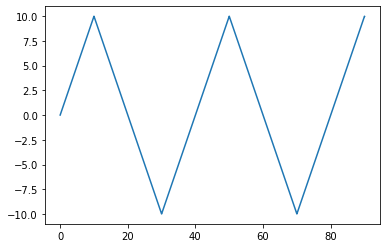

In [2457]:
# Fit time
fit_time = func(y_data,a,b,c)
plt.plot(y_data,fit_time)
plt.show()

In [2458]:
# Different(aka residual)
diff = x_data - fit_time

In [2459]:
# Smooth residual
dt_array = np.array(diff)
dt_array = pd.DataFrame(dt_array,columns=['diff'])
window_size = 5
dt_array['Moving_Average'] = dt_array['diff'].rolling(window=window_size).mean()

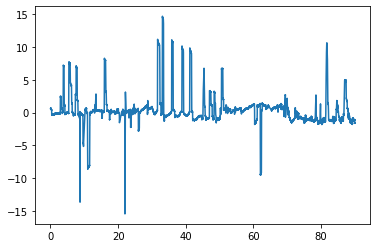

In [2460]:
plt.plot(y_data,dt_array['Moving_Average'])

In [2461]:
# create dataframe
data = {'Time':y_data,'POS':dt_array['Moving_Average']}
df = pd.DataFrame(data)

#### Choping the data

In [2462]:
# Plot specific range
x_start = 10.01
x_end = 90.00

# Filter the data points within the disired range using boolean indexing
mask = (df['Time'] >= x_start) & (df['Time'] <= x_end)
x_data_range = df.loc[mask]
#y_data_range = y_data[mask]

# create plot


#plt.plot(x_data_range['Time'],x_data_range['POS'])

#### From start to end data

In [2463]:
# x_data_range = df

In [2464]:
# Test 20 point
data = {'Time':x_data_range['Time'],'POS':x_data_range['POS']}
df_test = pd.DataFrame(data)

In [2465]:
# Determine the integration window
def check_sign(x):
    if x > 0:
        return "Positive"
    else:
        return "Negative"
df_test['Sign'] = df_test['POS'].apply(check_sign)

In [2466]:
# Condition window width 
def calculate_start_end(row):
    global last_positive, last_negative
    if row['Sign'] == 'Positive':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Positive':
            last_positive = row['Time']
            return last_positive, '', '', ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Positive':
            pos_end = row['Time']
            last_positive = ''
            return '', pos_end, '', ''
        else:
            return '', '', '', ''
    elif row['Sign'] == 'Negative':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', last_negative, ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', '', last_negative
        else:
            return '', '', '', ''
    else:
        return '', '', '', ''

# Initialize the last positive and negative values to empty strings 
last_positive = ''
last_negative = ''

# Reset the index of the DataFrame
df_test = df_test.reset_index(drop=True)

# Apply the custom function to create new columns
df_test['PosTim_Start'], df_test['PosTim_End'], df_test['NegTim_Start'], df_test['NegTim_End'] = zip(*df_test.apply(calculate_start_end, axis=1))

# Fill the empty cells with an empty string
df_test['PosTim_Start'] = df_test['PosTim_Start'].fillna('') 
df_test['PosTim_End'] = df_test['PosTim_End'].fillna('')
df_test['NegTim_Start'] = df_test['NegTim_Start'].fillna('')
df_test['NegTim_End'] = df_test['NegTim_End'].fillna('')

# Print the resulting dataframe 
#print(df_test)

#### Positive Time Start Trimming

In [2467]:
# Select the non-empty values in the 'Pos_Start' column
pos_start_values = df_test.loc[df_test['PosTim_Start'] != '', 'PosTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_pos_start_values = []
for value in pos_start_values:
    rounded_pos_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
postim_start_values = np.array(rounded_pos_start_values)

# Print the non-empty values
print(postim_start_values)

[10.19 10.68 10.74 10.77 10.92 11.75 11.77 11.81 11.95 12.01 12.03 12.07
 12.12 12.14 12.2  12.28 13.05 15.33 15.53 15.56 17.87 18.03 18.12 18.22
 18.86 19.53 19.54 19.55 19.64 20.09 20.3  21.02 21.36 21.68 22.13 22.43
 22.49 22.54 22.54 22.6  22.67 23.26 24.09 24.43 25.06 25.08 25.09 25.1
 25.13 25.16 25.18 26.29 26.35 26.38 26.45 26.49 26.52 28.68 28.73 30.52
 31.13 31.17 33.03 35.58 35.62 38.4  38.43 41.   41.04 41.08 45.08 46.98
 48.36 50.21 50.4  50.44 51.82 52.37 52.4  53.27 53.38 53.42 53.47 53.49
 53.52 53.6  54.47 56.49 61.13 62.4  69.19 69.56 70.3  72.26 72.74 78.33
 79.76 81.4  84.46 86.76]


#### Poisitive Time end Trimming

In [2468]:
# Select the non-empty values in the 'Pos_End' column
pos_end_values = df_test.loc[df_test['PosTim_End'] != '', 'PosTim_End'].values

# Round the values in the 'Pos_End' column to two decimal places
rounded_pos_end_values = []
for value in pos_end_values:
    rounded_pos_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
postim_end_values = np.array(rounded_pos_end_values)

# Print the non-empty values
print(postim_end_values)

[10.65 10.68 10.73 10.77 11.74 11.78 11.92 11.97 12.03 12.1  12.12 12.14
 12.24 13.01 15.21 15.5  15.54 17.4  18.   18.1  18.19 18.82 19.   19.53
 20.06 20.08 21.12 21.48 21.83 22.32 22.45 22.57 22.64 23.14 23.64 24.34
 24.95 25.06 25.1  25.14 25.15 25.94 26.31 26.38 26.49 28.64 28.67 30.46
 30.51 31.13 32.64 33.44 35.57 36.7  38.39 39.36 41.02 41.05 41.99 45.67
 47.78 48.76 50.27 50.39 51.79 52.3  52.37 53.24 53.32 53.38 53.44 53.47
 53.56 54.38 56.39 60.32 62.   69.01 69.44 70.2  70.53 72.42 72.83 78.52
 79.83 82.17 85.13 87.95]


In [2469]:
# # Read the dataset again
# path = os.getcwd()
# dirname = os.path.dirname(path)
# data_file = 'data/raw_pd0013_1.xlsx'
# data_path = os.path.join(dirname,data_file)
# # data = pd.read_csv(data_path)
# data= pd.read_excel(data_path)

In [2470]:
# Rename columns
data = data_hc.rename(columns={data_hc.columns.values[0]:"Position",
                               data_hc.columns.values[1]:'Time'})

#### Map the start positive Time to POS in raw data

In [2471]:
# Create a dictionary from the mapping list
mapping_list = postim_start_values

# Map the values to the 'POS' column in raw
mapped_posSt = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_posSt

3056     9.8523
3203     9.3750
3221     9.2540
3230     9.2137
3275     8.9919
          ...  
23498   -1.5758
23927   -0.1373
24419    1.4718
25337    4.7177
26027    6.6532
Name: Time, Length: 99, dtype: float64

#### Map the End positive Time to POS in raw data

In [2472]:
# Create a dictionary from the mapping list
mapping_list = postim_end_values

# Map the values to the 'POS' column in raw
mapped_posEnd = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_posEnd


3194     10.1815
3203      9.3750
3218      9.2944
3230      9.2137
3521      7.8629
          ...   
23555     0.8871
23948     1.2062
24650     2.9234
25538     5.2823
26384     8.2460
Name: Time, Length: 88, dtype: float64

In [2473]:
# postim_start_values = [1, 2, 3,4,5,6]  # Length 100
# mapped_posSt = [1, 2, 3,4]         # Length 80

# # Check lengths and truncate longer column 
# if len(postim_start_values) > len(mapped_posSt): 
#     postim_start_values = postim_start_values[:len(mapped_posSt)]  # Truncate to 80
# elif len(mapped_posSt) > len(postim_start_values):
#     mapped_posSt = mapped_posSt[:len(postim_start_values)]      # Truncate to 100

# # Construct DataFrame    
# data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}       
# param_gain_start = pd.DataFrame(data_param)

#### Velocity param positive dataframe

In [2474]:
# # column miss match
# Check lengths and truncate longer column 
if len(postim_start_values) > len(mapped_posSt): 
    postim_start_values = postim_start_values[:len(mapped_posSt)] 
elif len(mapped_posSt) > len(postim_start_values):
    mapped_posSt = mapped_posSt[:len(postim_start_values)]      

# Now columns have equal length 
data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}             
param_vel_start = pd.DataFrame(data_param)

data_param= {'positive_x2':postim_end_values,'positive_y2':mapped_posEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_positive_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_positive_final['Del_X'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']

# Remove short duration for 50 to 70
param_vel_positive_final = param_vel_positive_final[(param_vel_positive_final['Del_X'] > 0.3) & 
                                                    (param_vel_positive_final['Del_X'] < 2.07)]
#param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Del_X'] < 2.07]
#                                                     (param_vel_positive_final['Del_X'] < 2.07)]

#param_vel_positive_final = param_vel_positive_final.fillna(method='ffill')
#param_gain_final
param_vel_positive_final


,positive_x1,positive_y1,positive_x2,positive_y2,Del_X
0,10.19,9.8523,10.65,10.1815,0.46
4,10.92,8.9919,11.74,7.8629,0.82
13,12.14,7.9234,13.01,7.2379,0.87
17,15.33,5.0605,17.40,2.7419,2.07
20,17.87,2.0363,18.19,1.8145,0.32
21,18.03,1.9355,18.82,1.1492,0.79
22,18.12,1.9556,19.00,1.2500,0.88
23,18.22,1.8548,19.53,0.3629,1.31
24,18.86,1.1694,20.06,0.5242,1.20
25,19.53,0.3629,20.08,-0.1613,0.55


In [2475]:
param_vel_positive_final['Del_X'].sum()

23.87

In [2476]:
param_vel_positive_final.head(40)

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X
0,10.19,9.8523,10.65,10.1815,0.46
4,10.92,8.9919,11.74,7.8629,0.82
13,12.14,7.9234,13.01,7.2379,0.87
17,15.33,5.0605,17.40,2.7419,2.07
20,17.87,2.0363,18.19,1.8145,0.32
21,18.03,1.9355,18.82,1.1492,0.79
22,18.12,1.9556,19.00,1.2500,0.88
23,18.22,1.8548,19.53,0.3629,1.31
24,18.86,1.1694,20.06,0.5242,1.20
25,19.53,0.3629,20.08,-0.1613,0.55


#### Conditions

In [2477]:
param_vel_positive_final['Condition'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']
param_vel_positive_final['Condition'] =abs(param_vel_positive_final['Condition'])
param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Condition'] > 0.72]

In [2478]:
param_vel_positive_final['Del_X'].sum()

22.540000000000003

### Velocity for Positive peak calculation

In [2479]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])

# abs
param_vel_positive_final['slope'] = abs(param_vel_positive_final['slope'])

# Reindexing
param_vel_positive_final = param_vel_positive_final.reset_index(drop=True)

# Remove unwant values
#param_gain_positive_final.loc[param_gain_positive_final['slope'] > 1.09, 'slope'] = np.nan  

# Calculate the average slope
average_positive_slope = abs(param_vel_positive_final['slope'].mean())

# Print the average slope
#print(average_positive_slope)

/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_1818/725332997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])
/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_1818/725332997.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_positive_final['slope'] = abs(param_vel_posi

In [2480]:
#param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Del_X'] < 2]

In [2481]:
param_vel_positive_final

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X,Condition,slope
0,10.92,8.9919,11.74,7.8629,0.82,0.82,1.376829
1,12.14,7.9234,13.01,7.2379,0.87,0.87,0.787931
2,15.33,5.0605,17.40,2.7419,2.07,2.07,1.120097
3,18.03,1.9355,18.82,1.1492,0.79,0.79,0.995316
4,18.12,1.9556,19.00,1.2500,0.88,0.88,0.801818
5,18.22,1.8548,19.53,0.3629,1.31,1.31,1.138855
6,18.86,1.1694,20.06,0.5242,1.20,1.20,0.537667
7,19.54,0.4032,21.12,-1.0887,1.58,1.58,0.944241
8,19.55,0.3629,21.48,-1.0887,1.93,1.93,0.752124
9,21.02,-0.9960,22.57,-2.4194,1.55,1.55,0.918323


In [2482]:
# max_idx = param_vel_positive_final['slope'].idxmax()
# max_row = param_vel_positive_final.iloc[max_idx]
# max_row

#### Negative Time Start Trimming

In [2483]:
# Select the non-empty values in the 'Pos_Start' column
neg_start_values = df_test.loc[df_test['NegTim_Start'] != '', 'NegTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_start_values = []
for value in neg_start_values:
    rounded_neg_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
negtim_start_values = np.array(rounded_neg_start_values)

# Print the non-empty values
print(negtim_start_values)

[10.01 10.67 10.7  10.75 10.79 10.93 11.76 11.8  11.94 11.99 12.01 12.05
 12.12 12.14 12.16 12.26 13.03 15.23 15.52 15.56 17.42 18.02 18.12 18.21
 18.84 19.02 19.53 19.55 19.56 20.08 20.1  20.3  21.14 21.5  21.85 22.34
 22.47 22.5  22.54 22.59 22.66 23.16 23.66 24.36 24.97 25.08 25.08 25.09
 25.12 25.16 25.17 25.96 26.33 26.36 26.4  26.45 26.51 28.66 28.69 30.48
 30.53 31.15 32.66 33.46 35.59 36.72 38.41 39.38 41.04 41.07 42.01 45.69
 47.8  48.78 50.29 50.41 51.81 52.32 52.39 53.26 53.34 53.4  53.46 53.49
 53.49 53.58 54.4  56.41 60.34 62.02 69.03 69.46 70.22 70.55 72.44 72.85
 78.54 79.85 82.19 85.15 87.97]


#### Negative Time End Trimming

In [2484]:
# Select the non-empty values in the 'Pos_Start' column
neg_end_values = df_test.loc[df_test['NegTim_End'] != '', 'NegTim_End'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_end_values = []
for value in neg_end_values:
    rounded_neg_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
negtim_end_values = np.array(rounded_neg_end_values)

# Print the non-empty values
print(negtim_end_values)

[10.17 10.66 10.72 10.75 10.9  11.73 11.75 11.79 11.93 11.99 12.01 12.05
 12.18 12.26 13.03 15.31 15.51 17.85 18.01 18.84 19.51 19.53 19.62 20.07
 20.28 21.   21.34 21.66 22.11 22.41 22.47 22.52 22.58 22.65 23.24 24.07
 24.41 25.04 25.08 25.11 25.16 26.27 26.33 26.36 26.43 26.47 26.5  28.66
 28.71 30.5  31.11 31.15 33.01 35.56 35.6  38.38 38.41 40.98 41.06 45.06
 46.96 48.34 50.19 50.38 50.42 51.8  52.35 52.38 53.25 53.36 53.4  53.45
 53.5  53.58 54.45 56.47 61.11 62.38 69.17 69.54 70.28 72.24 72.72 78.31
 79.74 81.38 84.44 86.74]


#### Map the start negative Time to POS in raw data

In [2485]:
# Create a dictionary from the mapping list
mapping_list = negtim_start_values

# Map the values to the 'POS' column in raw
mapped_negSt = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_negSt

3002     7.8053
3200     9.0927
3209     9.2944
3224     9.0726
3236     9.1935
          ...  
23561   -1.9355
23954   -0.1537
24656    2.1169
25544    5.2419
26390    7.8831
Name: Time, Length: 99, dtype: float64

#### Map the End of negative Time to POS in raw data

In [2486]:
# Create a dictionary from the mapping list
mapping_list = negtim_end_values

# Map the values to the 'POS' column in raw
mapped_negEnd = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_negEnd

3050     9.6249
3197     9.4355
3215     9.2137
3224     9.0726
3269     9.1734
          ...  
23492   -1.9194
23921   -0.5211
24413    0.7863
25331    3.3065
26021    6.4113
Name: Time, Length: 88, dtype: float64

#### Velocity param negative dataframe

In [2487]:
# column miss match
# Check lengths and truncate longer column 
if len(negtim_start_values) > len(mapped_negSt): 
    negtim_start_values = negtim_start_values[:len(mapped_negSt)] 
elif len(mapped_negSt) > len(negtim_start_values):
    mapped_negSt = mapped_negSt[:len(negtim_start_values)]  


data_param = {'negative_x1':negtim_start_values,'negative_y1':mapped_negSt}             
param_vel_start = pd.DataFrame(data_param)
data_param= {'negative_x2':negtim_end_values,'negative_y2':mapped_negEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_negative_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_negative_final['Del_X'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
#param_vel_negative_final = param_vel_negative_final.fillna(method='ffill')
#param_vel_negative_final

# Remove short duration
# param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.3) & 
#                                                     (param_vel_negative_final['Del_X'] < 2.07)]
param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 2.07]
#                                                     


In [2488]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X
0,10.01,7.8053,10.17,9.6249,0.16
1,10.67,9.0927,10.66,9.4355,-0.01
2,10.70,9.2944,10.72,9.2137,0.02
3,10.75,9.0726,10.75,9.0726,0.00
4,10.79,9.1935,10.90,9.1734,0.11
5,10.93,8.9113,11.73,7.8226,0.80
6,11.76,8.0847,11.75,8.3468,-0.01
7,11.80,8.1250,11.79,8.1855,-0.01
8,11.94,7.9435,11.93,8.2056,-0.01
9,11.99,7.9435,11.99,7.9435,0.00


In [2489]:
param_vel_negative_final['Del_X'].sum()

26.12

#### Conditions

In [2490]:
param_vel_negative_final['Condition'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
param_vel_negative_final['Condition'] =abs(param_vel_negative_final['Condition'])
param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Condition'] > 1.01]

### Velocity for Negative peak calculation

In [2491]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
                                     - param_vel_negative_final['negative_y1']) / (param_vel_negative_final['negative_x2'] 
                                     - param_vel_negative_final['negative_x1'])

# abs
param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])

param_vel_negative_final['slope'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Reindexing
param_vel_negative_final = param_vel_negative_final.reset_index(drop=True)

# Remove unwant values
#param_gain_negative_final.loc[(param_gain_negative_final['slope'] < 0.80) |  
#                              (param_gain_negative_final['slope'] > 1.09), 
#                              'slope'] = np.nan
# Calculate the average slope
average_negative_slope = abs(param_vel_negative_final['slope'].mean())

# Print the average slope
print(average_negative_slope)

0.9906349482807862


/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_1818/2067333518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_1818/2067333518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])
/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_1818/2067333518.py:9: SettingWithCopyWarning: 


In [2492]:
# max_idx = param_vel_negative_final['slope'].idxmax()
# max_row = param_vel_negative_final.iloc[max_idx]
# max_row

In [2493]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X,Condition,slope
0,18.02,2.0363,19.53,0.3629,1.51,1.51,1.108212
1,18.12,1.9556,19.62,0.3226,1.50,1.50,1.088667
2,18.21,1.8347,20.07,0.0806,1.86,1.86,0.943065
3,18.84,1.1895,20.28,-0.2419,1.44,1.44,0.994028
4,19.02,0.9274,21.00,-1.0251,1.98,1.98,0.986111
5,19.53,0.3629,21.34,-1.4516,1.81,1.81,1.002486
6,21.14,-1.3911,22.58,-2.5806,1.44,1.44,0.826042
7,21.50,-1.7339,22.65,-2.6411,1.15,1.15,0.788870
8,21.85,-2.2379,23.24,-4.0524,1.39,1.39,1.305396
9,22.34,-2.3628,24.07,-4.3347,1.73,1.73,1.139827


In [2494]:
#param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 1.5]

In [2495]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X,Condition,slope
0,18.02,2.0363,19.53,0.3629,1.51,1.51,1.108212
1,18.12,1.9556,19.62,0.3226,1.50,1.50,1.088667
2,18.21,1.8347,20.07,0.0806,1.86,1.86,0.943065
3,18.84,1.1895,20.28,-0.2419,1.44,1.44,0.994028
4,19.02,0.9274,21.00,-1.0251,1.98,1.98,0.986111
5,19.53,0.3629,21.34,-1.4516,1.81,1.81,1.002486
6,21.14,-1.3911,22.58,-2.5806,1.44,1.44,0.826042
7,21.50,-1.7339,22.65,-2.6411,1.15,1.15,0.788870
8,21.85,-2.2379,23.24,-4.0524,1.39,1.39,1.305396
9,22.34,-2.3628,24.07,-4.3347,1.73,1.73,1.139827


In [2496]:
Final_Vel = pd.concat([param_vel_positive_final[['Del_X','slope']],
                       param_vel_negative_final[['Del_X','slope']]], axis=0, join='outer')

In [2497]:
Final_Vel

,Del_X,slope
0,0.82,1.376829
1,0.87,0.787931
2,2.07,1.120097
3,0.79,0.995316
4,0.88,0.801818
5,1.31,1.138855
6,1.20,0.537667
7,1.58,0.944241
8,1.93,0.752124
9,1.55,0.918323


In [2498]:
Final_Vel['Checked_velocity'] = Final_Vel['slope'] * Final_Vel['Del_X']
Vel = Final_Vel['Checked_velocity'].sum()/Final_Vel['Del_X'].sum()
Vel

0.9566859965635738

### Duration

In [2499]:
Final_Vel['Del_X'].sum()

46.56000000000001

In [2500]:
# total_vel = (average_positive_slope + average_negative_slope)/2


# total_vel

### Gain calculation

In [2501]:
speed = 1
total_gain = Vel/speed
print("The gain for this subject is:",total_gain)

The gain for this subject is: 0.9566859965635738
